# **The Preston Curve: Examining the relationship between income and life expectancy**

Imports and set magics:

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import ipywidgets as widgets
from matplotlib.lines import Line2D
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
#import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Read and clean data**

## **Dataset 1: World Bank development indicators**

We import data from the worldbanks databanks world development indicators. We import the data through a csv-file. The csv-file contains data for all 217 countries in the world. The included variables are GDP per capita in 2019, PPP current international $, life expectancy at birth in 2019, and population in 2019. 

In [64]:
wd = pd.read_csv('WorldData.csv') # Import data
wd.head() # Inspect data

,Country Name,Country Code,Series Name,Series Code,2019 [YR2019]
0,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,2167.70411054404
1,Afghanistan,AFG,"Mortality rate, under-5 (per 1,000 live births)",SH.DYN.MORT,59.9
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,37769499
3,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,63.565
4,Albania,ALB,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,14407.3656909018


We clean our dataset by deleting the colums we dont need, which is country code and series code. 

In [65]:
# We drop the following colums: country code and series code
drop_these = ['Country Code', 'Series Code']
wd.drop(drop_these, axis=1, inplace=True)
# rename columns
wd.rename(columns = {'Country Name':'country', 'Series Name':'index', '2019 [YR2019]':'val'}, inplace=True)
wd.head()

,country,index,val
0,Afghanistan,"GDP per capita, PPP (current international $)",2167.70411054404
1,Afghanistan,"Mortality rate, under-5 (per 1,000 live births)",59.9
2,Afghanistan,"Population, total",37769499
3,Afghanistan,"Life expectancy at birth, total (years)",63.565
4,Albania,"GDP per capita, PPP (current international $)",14407.3656909018


We want to reshape the data set, in order to have all the information for a country in one row. We have a long data set that we would like to reshape to a wide data set. We use the pivot_table function to do the reshape.

In [66]:
# reshape from long to wide
wd = wd.pivot_table(index='country', columns='index', values='val', aggfunc='sum').reset_index() # reset_index removes the second index created by the pivot
wd.head()


index,country,"GDP per capita, PPP (current international $)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)","Population, total"
0,Afghanistan,2167.70411054404,63.565,59.9,37769499
1,Albania,14407.3656909018,79.282,9.4,2854191
2,Algeria,12118.0045004936,76.474,23.5,42705368
3,American Samoa,..,..,..,47321
4,Andorra,..,..,3,76343


We change the variable names, such that there are no white spaces in columnames.

In [67]:
var_dict = {} # var is for variable
var_dict['GDP per capita, PPP (current international $)'] = 'gdp_per_cap'
var_dict['Life expectancy at birth, total (years)'] = 'life_exp'
var_dict['Mortality rate, under-5 (per 1,000 live births)'] = 'child_mort'
var_dict['Population, total'] = 'popl'

wd.rename(columns = var_dict,inplace=True)
wd.head()


index,country,gdp_per_cap,life_exp,child_mort,popl
0,Afghanistan,2167.70411054404,63.565,59.9,37769499
1,Albania,14407.3656909018,79.282,9.4,2854191
2,Algeria,12118.0045004936,76.474,23.5,42705368
3,American Samoa,..,..,..,47321
4,Andorra,..,..,3,76343


For the sake of future analysis we only want to keep data, where we have values for all variables. If there is not avaliable data for either gdp_per_cap, life_exp, child_mort or popl we delete the observation. This is the case for 37 countries in our dataset.

In [68]:
# create logical index
I = wd.gdp_per_cap == '..'
I |= wd.life_exp == '..'
I |= wd.child_mort == '..'
I |= wd.popl == '..'
wd.loc[I, :]
# print number of cases to delete
print(f'Number of cases to deletes = {sum(I)}')
# keep all other observations
wd = wd.loc[I == False]
wd.head()

Number of cases to deletes = 37


index,country,gdp_per_cap,life_exp,child_mort,popl
0,Afghanistan,2167.70411054404,63.565,59.9,37769499
1,Albania,14407.3656909018,79.282,9.4,2854191
2,Algeria,12118.0045004936,76.474,23.5,42705368
5,Angola,6881.07624117546,62.448,75,32353588
6,Antigua and Barbuda,24007.8684845165,78.691,6.6,92117


We see that American Samoa and Andorra now is deleted because of missing values. The same goes for the other 35 observations.

We see that there is a problem regarding the type of the variables. The dataframe has stored all the variabels as 'objects'.

In [69]:
wd.info() #We check the variable types in the dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 216
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      180 non-null    object
 1   gdp_per_cap  180 non-null    object
 2   life_exp     180 non-null    object
 3   child_mort   180 non-null    object
 4   popl         180 non-null    object
dtypes: object(5)
memory usage: 8.4+ KB


We change the variable types to the correct ones, so we can work with them.

In [70]:
# change types
wd.country = wd.country.astype('string')
wd.gdp_per_cap = wd.gdp_per_cap.astype(float)
wd.life_exp = wd.life_exp.astype(float)
wd.child_mort = wd.child_mort.astype(float)
wd.popl = wd.popl.astype(float)

wd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 216
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      180 non-null    string 
 1   gdp_per_cap  180 non-null    float64
 2   life_exp     180 non-null    float64
 3   child_mort   180 non-null    float64
 4   popl         180 non-null    float64
dtypes: float64(4), string(1)
memory usage: 8.4 KB


We change the population size to be in millions (this will make it easier for us to make a graph later)

In [71]:
wd.popl = wd.popl*(10**-6)
wd.head()

index,country,gdp_per_cap,life_exp,child_mort,popl
0,Afghanistan,2167.704111,63.565,59.9,37.769499
1,Albania,14407.365691,79.282,9.4,2.854191
2,Algeria,12118.004500,76.474,23.5,42.705368
5,Angola,6881.076241,62.448,75.0,32.353588
6,Antigua and Barbuda,24007.868485,78.691,6.6,0.092117


## **Dataset 2: Continents**

We import another dataset containing the continent for each contry. The data set origins from Our World in Data.

In [72]:
cd = pd.read_csv('ContinentData.csv') # Import data
cd.head() # Inspect data

,Entity,Code,Year,Continent
0,Abkhazia,OWID_ABK,2015,Asia
1,Afghanistan,AFG,2015,Asia
2,Akrotiri and Dhekelia,OWID_AKD,2015,Asia
3,Albania,ALB,2015,Europe
4,Algeria,DZA,2015,Africa


In [73]:
# We drop the following colums: Code and Year
drop_cont = ['Code', 'Year']
cd.drop(drop_cont, axis=1, inplace=True)
# rename columns
cd.rename(columns = {'Entity':'country', 'Continent':'continent'}, inplace=True)

#change types
cd.country = cd.country.astype('string')
cd.continent = cd.continent.astype('string')

# check correct types
cd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    285 non-null    string
 1   continent  285 non-null    string
dtypes: string(2)
memory usage: 4.6 KB


## **Merge datasets**

We merge the two dataframes wd and cd. We only want to keep observations which are available in both datasets. Therefore we use the 'inner'-method to merge the two data sets. We merge on the country variable which is common for the two datasets.

In [74]:
# merge datasets
wd_cont = pd.merge(wd, cd, how = 'inner', on = 'country')
print(f'Number of countries = {len(wd_cont.country.unique())}')

Number of countries = 161


Our merge using the 'inner'-method have further deleted 19 countries. We now have all the information we want for 161 countries. We believe that this is a sufficient number of observations for our analysis.

## **Examining Our Data**

In this section, we will examine our datasets by using some summary statistics. We begin by using the df.describe function. This gives us an overall view of our data.

In [75]:
# summary statistics
wd_cont.describe()

,gdp_per_cap,life_exp,child_mort,popl
count,161.000000,161.000000,161.000000,161.000000
mean,21965.064433,72.512273,27.859627,43.336329
std,22356.903824,7.679809,29.524220,159.716332
min,760.453399,52.910000,2.300000,0.010956
25%,5033.365324,66.437000,6.400000,2.664224
50%,14407.365691,73.931000,14.900000,9.542486
75%,32874.891025,78.691000,42.800000,30.285595
max,120174.754704,84.356341,118.600000,1407.745000


If we look at life expectancy, this function provides us information about:
- The average life expectancy in the world is 72.5 years.
- The lowest life expectancy for a country in the world is 52.9 years.
- The 25th (50th, 75th) percentile country of those with the lowest life expectancy expects to live 66.4 (73.9, 78.7) years.
- The highest life expectancy for a country in the world is 84.4 years.

To further examine the data, with regards to our later graphs, we will look at the average life expectancy across continents.

*Average life expectancy by continent:*

In [80]:
# using groupedby to calculate within means
wd_grouped1 = wd_cont.groupby(['continent'])['life_exp'].mean() # by life expectancy
wd_grouped2 = wd_cont.groupby(['continent'])['gdp_per_cap'].mean() # by income
# print all continents
print(f'Average life expectancy by: {wd_grouped1}')
print(f'Average income by: {wd_grouped2}')

Average life expectancy by: continent
Africa           63.744898
Asia             74.698759
Europe           79.598422
North America    74.932977
Oceania          71.268932
South America    74.862636
Name: life_exp, dtype: float64
Average income by: continent
Africa            6312.802242
Asia             24107.523985
Europe           42876.500049
North America    20710.501691
Oceania          14199.725736
South America    16803.001374
Name: gdp_per_cap, dtype: float64


We see how life expectancy varies across continents. The average life expectancy in Africa is the lowest in the world with a life expectancy of 63.7 years, while the average life expectancy in Europe is 79.6 years and the highest average in the world.

We plot this in a bar chart.

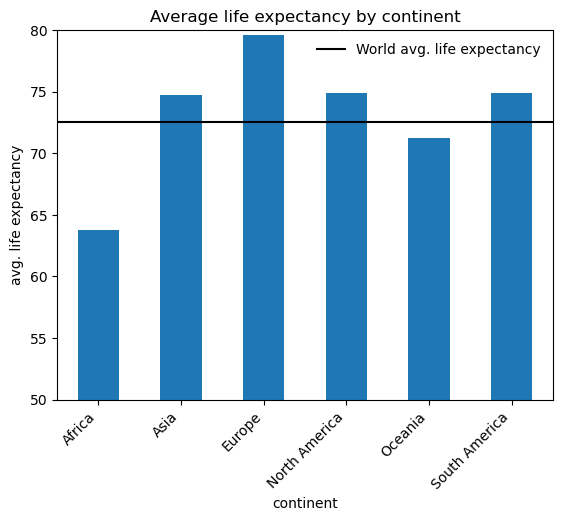

In [88]:
# create figure
fig = plt.figure()
# create plot as bar chart
ax = fig.add_subplot(1,1,1)
wd_grouped1.plot(kind='bar', label='_nolegend_')
# alterations to plot
plt.ylim(50,80)
plt.xticks(rotation=45, ha='right')
ax.set_title("Average life expectancy by continent")
ax.set_ylabel("avg. life expectancy")
# add world average life expectancy as horizontal line
plt.axhline(y = np.nanmean(wd_cont.life_exp), color='black', label='World avg. life expectancy')
plt.legend(frameon=False)
plt.show()



We see that Africa and Oceania have average life expectancies below the world average. The average life expectancy in Africa is 8.8 years lower than the world average. To examine this further, we will present the Preston Curve in the next section as well as child mortality across continents.

We do the same for income across continents

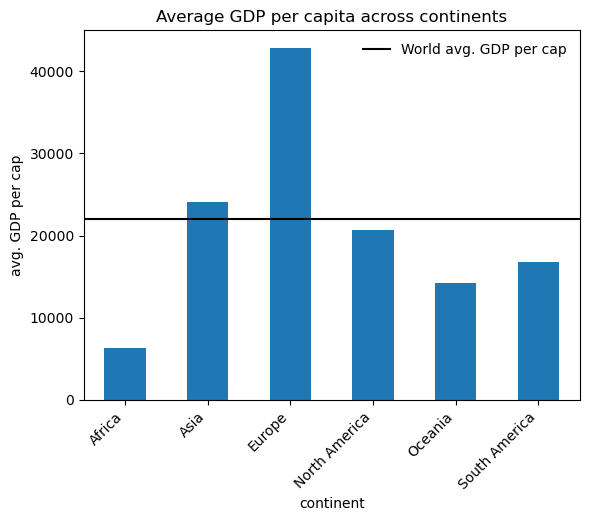

In [89]:
# create figure
fig = plt.figure()
# create plot as bar chart
ax = fig.add_subplot(1,1,1)
wd_grouped2.plot(kind='bar', label='_nolegend_')
# alterations to plot
plt.xticks(rotation=45, ha='right')
ax.set_title("Average GDP per capita across continents")
ax.set_ylabel("avg. GDP per cap")
# add world average life expectancy as horizontal line
plt.axhline(y = np.nanmean(wd_cont.gdp_per_cap), color='black', label='World avg. GDP per cap')
plt.legend(frameon=False)
plt.show()

## **The Preston Curve**

We want to show the relationship between income and life expentancy for all countries which contains data for both. Using a scatterplot we get the following relationship.

Text(0, 0.5, 'Life expantancy at birth, 2019')

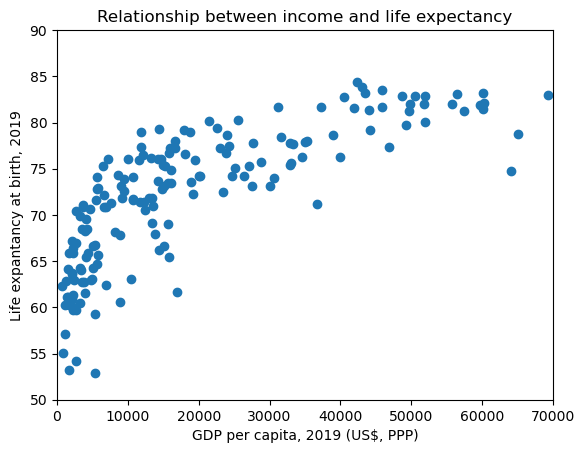

In [249]:
fig = plt.figure() #Create figure
ax = fig.add_subplot(1,1,1) #Create plot
plt.scatter(wd.gdp_per_cap, wd.life_exp)

#Alterations to figure
ax.set(xlim=(0, 70000), ylim=(50, 90))
ax.set_title('Relationship between income and life expectancy')
ax.set_xlabel('GDP per capita, 2019 (US$, PPP)')
ax.set_ylabel('Life expantancy at birth, 2019')


We have now show the relationship between the income and life expectancy with a simple figure. Using our learned skills we will make the figure look nice and more readable.

We create a dictionary where we asign a colour to each continent

In [250]:
colours = {
    'Africa':'purple',
    'Asia':'yellow',
    'Europe':'green',
    'North America':'blue',
    'Oceania':'red',
    'South America':'orange'
}

In [251]:
# map dictionary of colours over continents to assign the correct colours for each continent
wd_cont['colour'] = wd_cont['continent'].map(colours)
wd_cont.head()

,country,gdp_per_cap,life_exp,child_mort,popl,continent,colour
0,Afghanistan,2167.704111,63.565,59.9,37.769499,Asia,yellow
1,Albania,14407.365691,79.282,9.4,2.854191,Europe,green
2,Algeria,12118.004500,76.474,23.5,42.705368,Africa,purple
3,Angola,6881.076241,62.448,75.0,32.353588,Africa,purple
4,Antigua and Barbuda,24007.868485,78.691,6.6,0.092117,North America,blue


We will now present the Preston Curve. In the plot we will colour coordinate the continents to visually show how life expectancy varies across continents as seen in the bar chart above. Furthermore, we will population size of each country into account when presenting each observation in the scatter plot.

            2
-3.994e-09 x + 0.0005767 x + 63.76


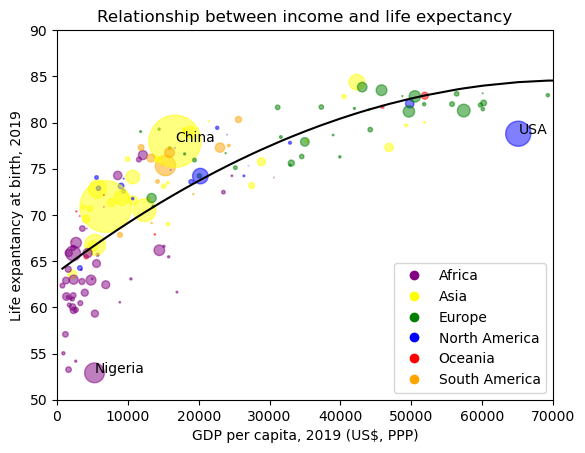

In [262]:
fig = plt.figure() #Create figure
ax = fig.add_subplot(1,1,1) #Create plot
plt.scatter(wd_cont.gdp_per_cap, wd_cont.life_exp, s = wd_cont.popl, c=wd_cont['colour'], alpha=0.5) #We add s equal to the population size

# add fitted line
z = np.polyfit(wd_cont.gdp_per_cap, wd_cont.life_exp, 2)
p = np.poly1d(z)
print(p)
sorted = np.sort(wd_cont.gdp_per_cap)
plt.plot(sorted, p(sorted), color='black')

# add text to selected countries
china_index = wd_cont.loc[wd_cont.country == "China"].index[0]
plt.text(wd_cont.gdp_per_cap[china_index], wd_cont.life_exp[china_index], "China")
nigeria_index = wd_cont.loc[wd_cont.country == "Nigeria"].index[0]
plt.text(wd_cont.gdp_per_cap[nigeria_index], wd_cont.life_exp[nigeria_index], "Nigeria")
usa_index = wd_cont.loc[wd_cont.country == "United States"].index[0]
plt.text(wd_cont.gdp_per_cap[usa_index], wd_cont.life_exp[usa_index], "USA")

#Alterations to figure
ax.set(xlim=(0, 70000), ylim=(50, 90))
ax.set_title('Relationship between income and life expectancy')
ax.set_xlabel('GDP per capita, 2019 (US$, PPP)')
ax.set_ylabel('Life expantancy at birth, 2019')
# add legend: colours corresponding to continents
legend_elements = [Line2D([0],[0], marker='o', color=colour, linestyle='') for colour in colours.values()]
ax.legend(legend_elements, colours.keys(), numpoints=1)

From the figure we see that life expectancy grows rapidly for higher incomes. For low incomes a small increase in income implies large increases in life expectancy. At higher incomes, the increase in expected longevity seems to become smaller and smaller. As expected, the countries with the lowest life expectnancy can be found in Africa, as we see a larger concentration of the purple colour in the lower left area of the plot. Likewise, we see a large concentration of the green colour representing Europe in the upper right corner of the plot. For Oceania, the life expectancy was below the world average. From this plot it becomes noticeable that it is a few countries dragging down the average as we have some countries in Oceania in the upper right corner of the plot and some countries in the left side of the plot with low income and low life expectancy.

After having presented the Preston curve, we want to present why especially Africa has a very low life expectancy. This is due to the fact that child mortality is very high in this region contrary to the more developed parts of the world where income is higher.

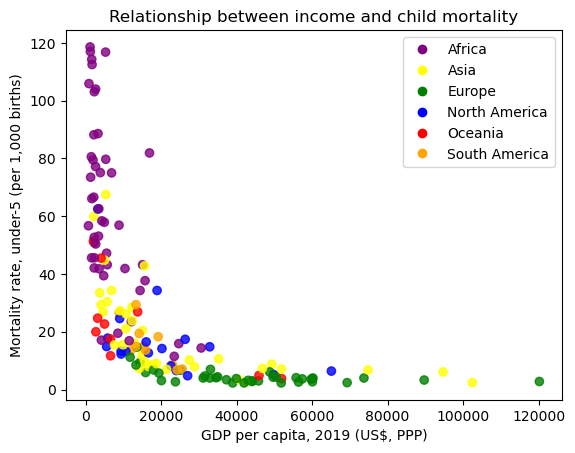

In [266]:
fig = plt.figure() #Create figure
ax = fig.add_subplot(1,1,1) #Create plot
plt.scatter(wd_cont.gdp_per_cap, wd_cont.child_mort, c=wd_cont['colour'], alpha=0.8)

#Alterations to figure
ax.set_title('Relationship between income and child mortality')
ax.set_xlabel('GDP per capita, 2019 (US$, PPP)')
ax.set_ylabel('Mortality rate, under-5 (per 1,000 births)')
# add legend: colours corresponding to continents
legend_elements = [Line2D([0],[0], marker='o', color=colour, linestyle='') for colour in colours.values()]
ax.legend(legend_elements, colours.keys(), numpoints=1)

# Conclusion

ADD CONCISE CONLUSION.